#Sienna Gaita-Monjaraz
#CAP4770
# 10/3/2023

# Assignment: 2


# Dataset:
You will be working with two datasets: Train and Test, both containing images of 40 individuals. Each dataset has been preprocessed for this assignment.

In [4]:
# Import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from tabulate import tabulate

In [5]:
# Load the training and testing data from CSV files into pandas DataFrames
train_data = pd.read_csv('TrainData.csv')
test_data = pd.read_csv('TestData.csv')

# Extract the last column from both training and testing data, assuming it's the label column
train_labels = train_data.iloc[:,-1]
test_labels = test_data.iloc[:,-1]

# Convert the labels from pandas Series to numpy arrays for easier calculations later on
train_labels = train_labels.to_numpy()
test_labels = test_labels.to_numpy()

# Reverse the order of rows in both training and testing data
train_datax = train_data.iloc[::-1]
test_datax = test_data.iloc[::-1]

# Convert the reversed DataFrames to numpy arrays
Train = train_datax.to_numpy()
Test = test_datax.to_numpy()

# Print the shape (dimensions) of the training data to understand its structure
print(Train.shape)


(200, 10305)


#Part 1: Principal Component Analysis (PCA)

##1.1 Implement PCA from Scratch:

a. Write Python code to implement PCA from scratch.

In [6]:
def my_pca(Data, k):
    # Calculate the mean of the data for each feature
    avg = np.mean(Data, axis=0)

    # Subtract the mean to center the data around the origin
    Data = Data - avg

    # Calculate the covariance matrix of the centered data
    cov = np.cov(Data, rowvar=False)

    # Derive eigenvalues and eigenvectors from the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov)

    # Sort the eigenvalues in descending order and get their indices
    idx = np.argsort(eigenvalues)[::-1]

    # Reorder the eigenvalues based on the sorted indices
    eigenvalues = eigenvalues[idx]

    # Reorder the eigenvectors to match the order of eigenvalues
    eigenvectors = eigenvectors[:, idx]

    # Choose the first 'k' eigenvectors
    reduce_eigenvectors = eigenvectors[:, :k]

    # Transform the data to the lower-dimensional space defined by the top 'k' eigenvectors
    transformed_data = np.dot(Data, reduce_eigenvectors)

    # Return the transformed data, the 'k' eigenvectors, and the mean of the input data
    return transformed_data, reduce_eigenvectors, avg


b. Apply your PCA implementation to the Train dataset to reduce the dimensionality of the images.


In [7]:
Train_new , reduce_eigenvectors , avg = my_pca(Train,110)

c. Choose an appropriate number of principal components to retain a significant amount of variance (95%)

In [8]:
pca_all = PCA()
pca_all.fit(train_data.iloc[:, 1:].values)

# Find optimal value of 'k' (number of principal components)
# by identifying the smallest number of components that retain at least 95% of the total variance.
# We use the cumulative explained variance provided by PCA to find this threshold.
# Calculate the cumulative sum of explained variance ratios
cumulative_variance = np.cumsum(pca_all.explained_variance_ratio_)

# Find the number of components needed to retain 95% variance
k = np.argmax(cumulative_variance >= 0.95) + 1

# Display the determined k value
print(f"Optimal number of components (k) to retain 95% variance: {k}")

Optimal number of components (k) to retain 95% variance: 110


## 1.2 Apply pca using scikit-learn

a. Import the PCA module from sklearn. [Already imported at the top]

b. Apply PCA to the Train dataset using sklearn

In [9]:
#apply PCA using sklearn
pca = PCA(n_components=110)
pca.fit(Train)
Train_new_sklearn = pca.transform(Train)

In [10]:
#Shape verification

#Sklearn's PCA
print("Sklearn's PCA :", Train_new_sklearn.shape)
#My own PCA
print("My own PCA :", Train_new.shape)

Sklearn's PCA : (200, 110)
My own PCA : (200, 110)


#Part 2:Kernel PCA (KPCA)

## 2.1 KPCA with RBF Kernel:

a. Implement Kernel PCA with the Radial Basis Function (RBF) kernel from scratch.

In [11]:
def rbf_kernel(x, y, gamma=1.0):
    """
    Radial Basis Function (RBF) kernel.
    """
    distance = np.linalg.norm(x - y) ** 2
    return np.exp(-gamma * distance)


In [12]:
def my_kpca(data, k, kernel_type='rbf', kernel_param=1.0):
    """
    Kernel Principal Component Analysis (KPCA) function.

    Parameters:
    - data: Input data as an ndarray of shape (n_samples, n_features).
    - k: Number of principal components to retain.
    - kernel_type: Type of kernel ('rbf', 'poly', or 'linear').
    - kernel_param: Kernel parameter (e.g., gamma for RBF, degree for polynomial).

    Returns:
    - Transformed data in the KPCA space.
    """
    # Determine the number of samples in the data
    n_samples = data.shape[0]

    # Initialize a square matrix with zeros to store the kernel values
    K = np.zeros((n_samples, n_samples))

    # Populate the kernel matrix 'K' by computing kernel values between each pair of samples
    for i in range(n_samples):
        for j in range(n_samples):
            # Check which kernel type is selected and compute the kernel value accordingly
            if kernel_type == 'rbf':
                K[i, j] = rbf_kernel(data[i], data[j], gamma=kernel_param)
            elif kernel_type == 'poly':
                K[i, j] = poly_kernel(data[i], data[j], degree=kernel_param)
            elif kernel_type == 'linear':
                K[i, j] = linear_kernel(data[i], data[j])
            else:
                # If the specified kernel type is not one of the recognized types, raise an error
                raise ValueError("Unknown kernel type.")

    # Center the kernel matrix using the kernel centering technique
    one_n = np.ones((n_samples, n_samples)) / n_samples
    centered_kernel_matrix = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtain eigenvalues and eigenvectors from the centered kernel matrix
    eigenvalues, eigenvectors = np.linalg.eigh(centered_kernel_matrix)

    # Sort the eigenvectors based on the descending order of their corresponding eigenvalues
    idx = eigenvalues.argsort()[::-1]
    eigenvectors = eigenvectors[:, idx]

    # Retain only the top 'k' eigenvectors
    top_eigenvectors = eigenvectors[:, :k]

    # Transform the data by projecting it onto the top 'k' eigenvectors of the centered kernel matrix
    transformed_data = np.dot(centered_kernel_matrix, top_eigenvectors)

    # Return the data transformed into the new space defined by the top 'k' eigenvectors
    return transformed_data

b. Apply your KPCA implementation to the Train dataset.


In [13]:
#kpca using rbf
kpca_train_rbf_data = my_kpca(Train, 110, kernel_type='rbf')

## 2.2 PCA with Polynomial Kernel:

a. Implement Kernel PCA with a Polynomial kernel from scratch.


In [14]:
def poly_kernel(x, y, degree=3):
    """
    Polynomial kernel.
    """
    return (np.dot(x, y) + 1) ** degree


b. Apply your KPCA implementation to the Train dataset.

In [15]:
#kpca using poly
kpca_train_poly_data = my_kpca(Train, 110, kernel_type='poly')

##2.3 KPCA with linear Kernel:

a. Implement Kernel PCA with a Polynomial kernel from scratch.

In [16]:
def linear_kernel(x, y):
    """
    Linear kernel.
    """
    return np.dot(x, y)

b. Apply your KPCA implementation to the Train dataset.

In [17]:
#kpca using linear
kpca_train_linear_data = my_kpca(Train, 110, kernel_type='linear')

#Part 3: Testing and Evaluation

##3.1 Applying PCA and KPCA to the Test Dataset:

a. Use the PCA and KPCA models (both RBF and Polynomial) trained on the Train dataset to transform the Test dataset


In [19]:
# Initialize KernelPCA models with different kernel types: RBF, Polynomial, and Linear.
kpca_rbf = KernelPCA(kernel="rbf", n_components =110)
kpca_poly= KernelPCA(kernel="poly", n_components =110)
kpca_linear= KernelPCA(kernel="linear", n_components =110)

# Use the training data to fit and transform using the KernelPCA model with different kernel types: RBF, Polynomial, and Linear.
sklearn_train_data_rbf = kpca_rbf.fit_transform(Train)
sklearn_train_data_poly = kpca_poly.fit_transform(Train)
sklearn_train_data_linear = kpca_linear.fit_transform(Train)

In [20]:
#applying pca on test data
Test_new_center = Test - avg
Test_new = np.dot(Test_new_center, reduce_eigenvectors)


#applying sklearn pca on test data
Test_new_sklearn = pca.transform(Test)


#applying kpca on test data
kpca_test_rbf_data = my_kpca(Test, 110, kernel_type='rbf')
kpca_test_poly_data = my_kpca(Test, 110, kernel_type='poly')

#applying sklearn kpca on test data
sklearn_test_data_rbf = kpca_rbf.transform(Test)
sklearn_test_data_poly = kpca_poly.transform(Test)

b. Ensure that the dimensionality reduction is consistent with the training data.

In [21]:

# Prepare the data for the table
methods = ["PCA", "KPCA with rbf", "KPCA with poly"]
my_shapes = [Test_new.shape, kpca_test_rbf_data.shape, kpca_test_poly_data.shape]
sklearn_shapes = [Test_new_sklearn.shape, sklearn_test_data_rbf.shape, sklearn_test_data_poly.shape]

table = list(zip(methods, my_shapes, sklearn_shapes))

# Print the table
print(tabulate(table, headers=['Method', 'My Implementation Shape', 'Sklearn Shape'], tablefmt="rst"))


==============  =========================  ===============
Method          My Implementation Shape    Sklearn Shape
==============  =========================  ===============
PCA             (200, 110)                 (200, 110)
KPCA with rbf   (200, 110)                 (200, 110)
KPCA with poly  (200, 110)                 (200, 110)
==============  =========================  ===============


##3.2 Classification Experiment:

a. Choose a minimum distance classifier to classify the 'TestDataset'

In [22]:
# Function to calculate distance between two points
def dis(x1, x2):
    return np.linalg.norm(x1 - x2)

# Function to perform classification
def myclassifier(Train, Trainlabel, Test):
    " Train is the training data"
    " Trainlabel is the training labels"
    " Test is the testing data"
    pred = []

    for testpoint in Test:
        pred_dis = []
        for trainpoint in Train:
            pred_dis.append(dis(testpoint, trainpoint))

        pred.append(Trainlabel[np.argmin(pred_dis)])

    return np.array(pred)

 b. Evaluate the classification performance on the Test dataset using accuracy metrics

In [23]:
def calculate_accuracy(true_labels, predicted_labels):
    # Ensure that the true labels and predicted labels have the same length
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Length of true_labels and predicted_labels must be the same.")

    # Count the number of correct predictions
    correct_predictions = sum(1 for true, predicted in zip(true_labels, predicted_labels) if true == predicted)

    # Calculate accuracy as the ratio of correct predictions to total predictions
    accuracy = correct_predictions / len(true_labels)

    return accuracy

In [24]:
''' Using my Function '''

#prediction using pca
prediction = myclassifier(Train_new, train_labels, Test_new)

#prediction using kpca with rbf
prediction_rbf = myclassifier(kpca_train_rbf_data, train_labels, kpca_test_rbf_data)

#prediction using kpca with poly
prediction_poly = myclassifier(kpca_train_poly_data, train_labels, kpca_test_poly_data)


''' Using Sklearn Function '''

#prediction using pca
prediction_sklearn = myclassifier(Train_new_sklearn, train_labels, Test_new_sklearn)

#prediction using kpca with rbf
prediction_rbf_sklearn = myclassifier(sklearn_train_data_rbf, train_labels, sklearn_test_data_rbf)

#prediction using kpca with poly
prediction_poly_sklearn = myclassifier(sklearn_train_data_poly, train_labels, sklearn_test_data_poly)


In [25]:
#accuracy using pca
accuracy = calculate_accuracy(test_labels, prediction)
#accuracy using kpca with rbf
accuracy_rbf = calculate_accuracy(test_labels, prediction_rbf)
#accuracy using kpca with poly
accuracy_poly = calculate_accuracy(test_labels, prediction_poly)

''' Using Sklearn Function '''
sklearn_accuracy = calculate_accuracy(test_labels, prediction_sklearn)
sklearn_accuracy_rbf = calculate_accuracy(test_labels, prediction_rbf_sklearn)
sklearn_accuracy_poly = calculate_accuracy(test_labels, prediction_poly_sklearn)

# Prepare the data for the table
labels = ["PCA", "KPCA with rbf", "KPCA with poly"]
my_accuracies = [accuracy*100, accuracy_rbf*100, accuracy_poly*100]
sklearn_accuracies = [sklearn_accuracy*100, sklearn_accuracy_rbf*100, sklearn_accuracy_poly*100]

table = list(zip(labels, my_accuracies, sklearn_accuracies))

# Print the table j
print(tabulate(table, headers=['Method', 'My Implementation (%)', 'Sklearn (%)'], tablefmt="rst", floatfmt=".2f"))

==============  =======================  =============
Method            My Implementation (%)    Sklearn (%)
==============  =======================  =============
PCA                               88.50          88.50
KPCA with rbf                    100.00           2.50
KPCA with poly                    11.50          87.00
==============  =======================  =============


#Visualizations

In [26]:
# Create a dictionary to hold the statistics
data_stats = {
    'Statistic': [
        "TrainData shape",
        "TestData shape",
        "Size of TestData",
        "Minimum value in TestData",
        "Maximum value in TestData"
    ],
    'Value': [
        str(train_data.shape),
        str(test_data.shape),
        test_data.size,
        np.min(test_data.values.ravel()),
        np.max(test_data.values.ravel())
    ]
}

# Convert the dictionary to a DataFrame
df_stats = pd.DataFrame(data_stats)

# Display the DataFrame in a table with left-aligned text inside
print(tabulate(df_stats, headers='keys', tablefmt='rst', showindex=False, numalign="left"))


=========================  ============
Statistic                  Value
=========================  ============
TrainData shape            (200, 10305)
TestData shape             (200, 10305)
Size of TestData           2061000
Minimum value in TestData  0
Maximum value in TestData  255
=========================  ============


Visualize the closest match from the training set to a given test image using PCA


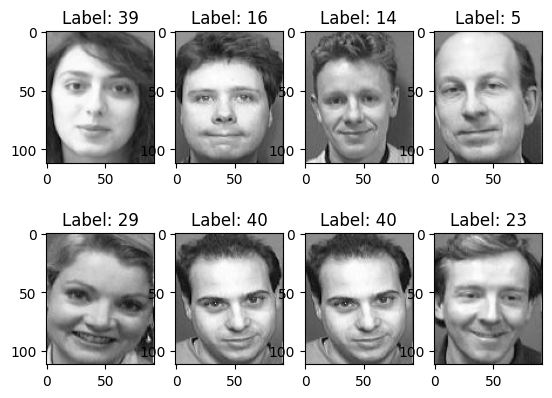

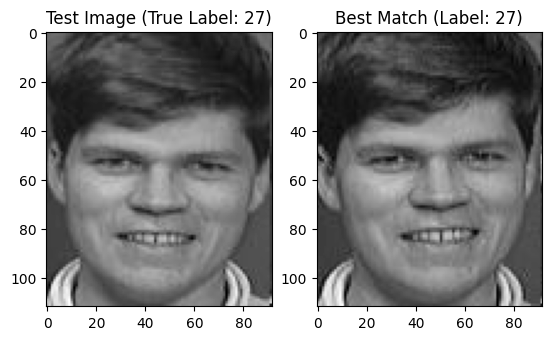

In [27]:
fig, axes = plt.subplots(2, 4)

indices = np.random.choice(200, 8)

# Loop through each subplot axis and show the corresponding image from the training dataset
for i, ax in enumerate(axes.flat):
    # Get the random index for this subplot
    idx = indices[i]
    x = train_data.iloc[idx, 1:].values

    # Get the label associated with this data
    label = train_labels[idx]

    # Check if the size of the data corresponds to an image of size 112x92
    if x.size == 112 * 92:
        # Reshape the 1D array into a 2D array of shape 112x92
        image = x.reshape(112, 92)

        # Display the image in grayscale
        ax.imshow(image, cmap='gray')

        # Set the title of the subplot to the label
        ax.set_title(f'Label: {label}')
    else:
        # Print an error if the data cannot be reshaped into the desired dimensions
        print("Cannot reshape the array with the given dimensions.")


def visualize_best_match(train_data, test_data, true_label, k):

    # Initialize PCA with 'k' components
    pca = PCA(k)

    # Fit PCA on the training data (ignoring the first column)
    pca.fit(train_data.iloc[:, 1:].values)

    # Transform the test image using PCA
    if isinstance(test_data, pd.DataFrame):
        reduced_test = pca.transform(test_data.iloc[:, 1:].values)
    else:
        reduced_test = pca.transform(test_data.reshape(1, -1))

    # Calculate distances between the test image and all training images in the PCA-transformed space
    distances = np.linalg.norm(pca.transform(train_data.iloc[:, 1:].values) - reduced_test, axis=1)

    # Get the index of the closest image in the training dataset to the test image
    best_match_index = np.argmin(distances)

    # Extract this image's data
    best_match_data = train_data.iloc[best_match_index, 1:].values

    # Reshape both the test image and its closest match to 2D arrays for visualization
    test_image_reshaped = test_data.reshape(112, 92)
    best_match_image_reshaped = best_match_data.reshape(112, 92)

    # Create a new figure with 2 subplots side by side
    fig, axes = plt.subplots(1, 2)

    # Display the test image on the left and its closest match on the right
    axes[0].imshow(test_image_reshaped, cmap='gray')
    axes[0].set_title(f'Test Image (True Label: {true_label})')
    axes[1].imshow(best_match_image_reshaped, cmap='gray')
    axes[1].set_title(f'Best Match (Label: {true_label})')

    # Show the figure
    plt.show()

idx1 = np.random.choice(test_data.shape[0], 1)[0]
testIMG = test_data.iloc[idx1, 1:].values
TrueLabel = test_labels[idx1]

visualize_best_match(train_data, testIMG, TrueLabel, k)

Scatter plots for my own functions

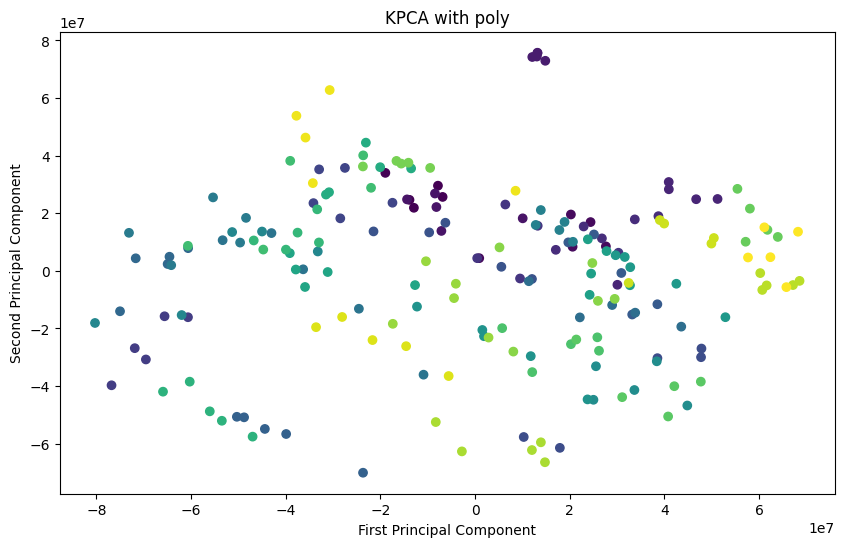

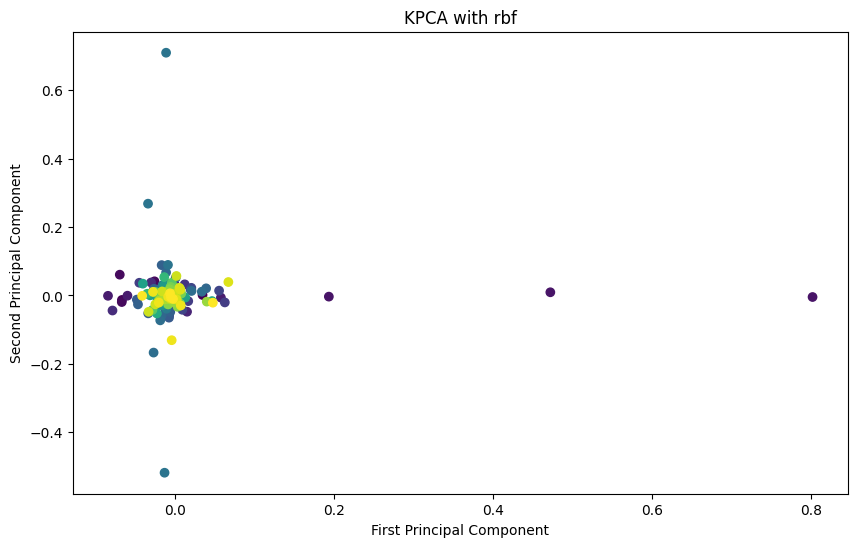

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


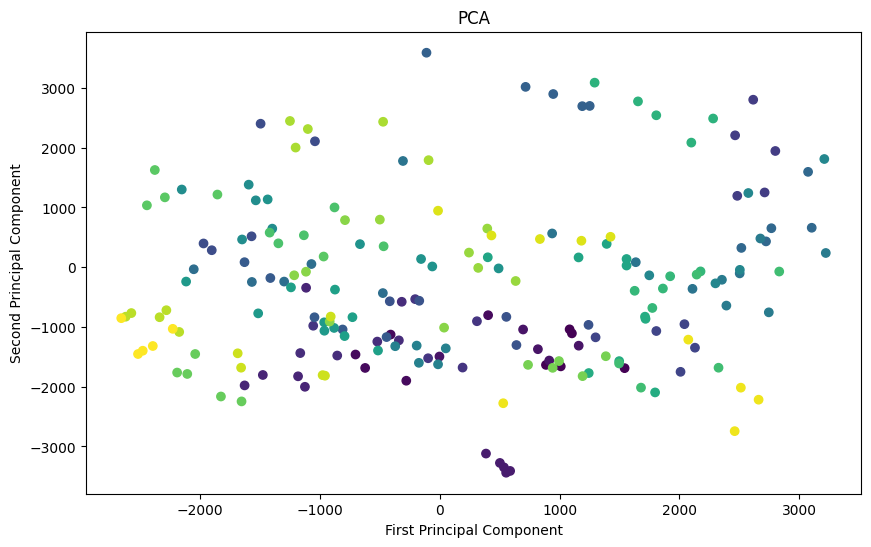

In [28]:
#scatterplot for kpca with poly
plt.figure(figsize=(10, 6))
plt.scatter(kpca_test_poly_data[:, 0], kpca_test_poly_data[:, 1], c=train_labels)
plt.title('KPCA with poly')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

#scatterplot for kpca with rbf
plt.figure(figsize=(10, 6))
plt.scatter(kpca_test_rbf_data[:, 0], kpca_test_rbf_data[:, 1], c=train_labels)
plt.title('KPCA with rbf')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

#scatterplot for pca
plt.figure(figsize=(10, 6))
plt.scatter(Test_new[:, 0], Test_new[:, 1], c=train_labels)
plt.title('PCA')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()


Scatter Plot of SKlearn function

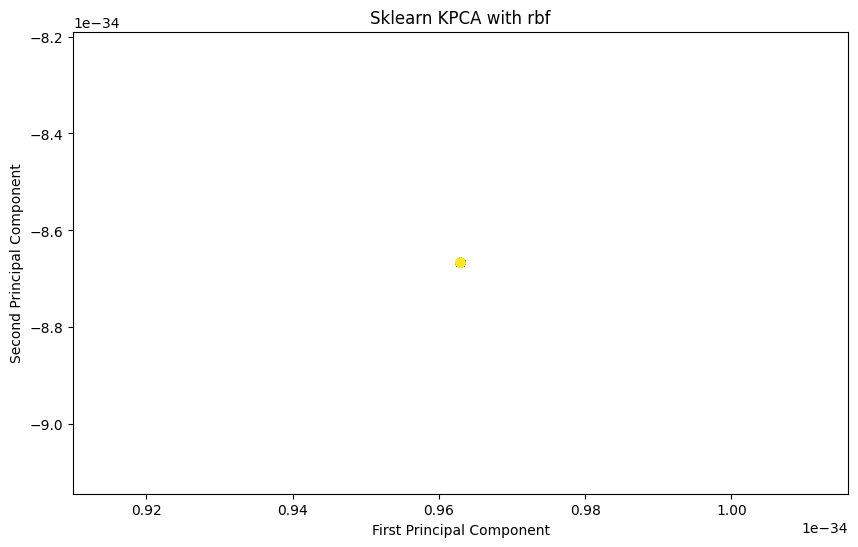

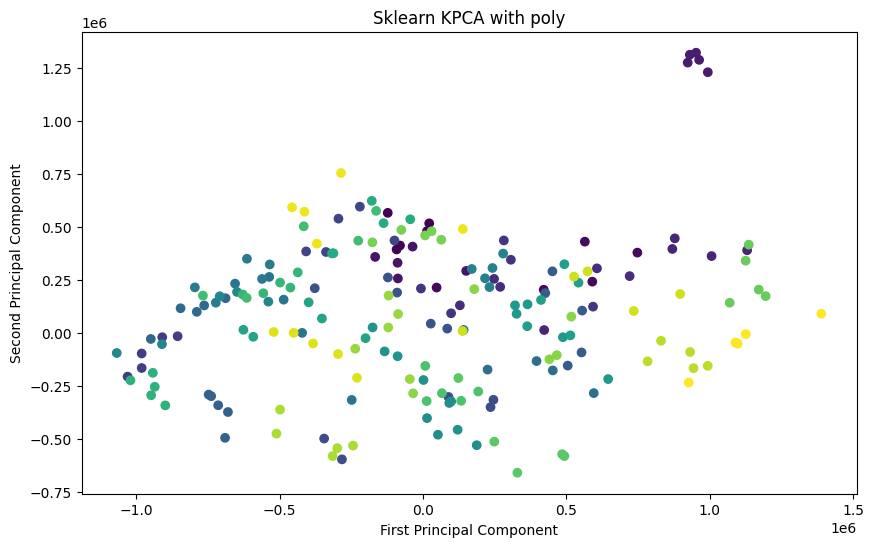

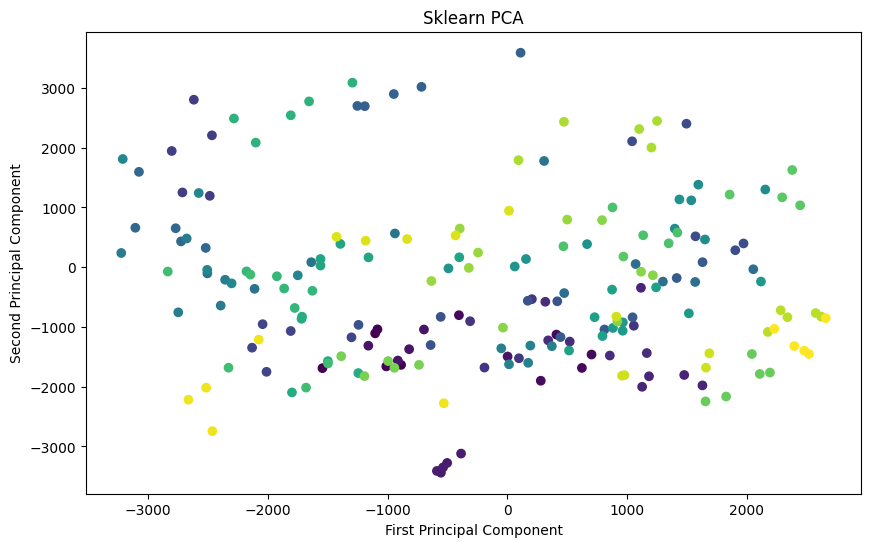

In [29]:
#RBF
plt.figure(figsize=(10, 6))
plt.scatter(sklearn_test_data_rbf[:, 0], sklearn_test_data_rbf[:, 1], c=train_labels)
plt.title('Sklearn KPCA with rbf')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

#Poly
plt.figure(figsize=(10, 6))
plt.scatter(sklearn_test_data_poly[:, 0], sklearn_test_data_poly[:, 1], c=train_labels)
plt.title('Sklearn KPCA with poly')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

#scatterplot for sklearn pca
plt.figure(figsize=(10, 6))
plt.scatter(Test_new_sklearn[:, 0], Test_new_sklearn[:, 1], c=train_labels)
plt.title('Sklearn PCA')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()


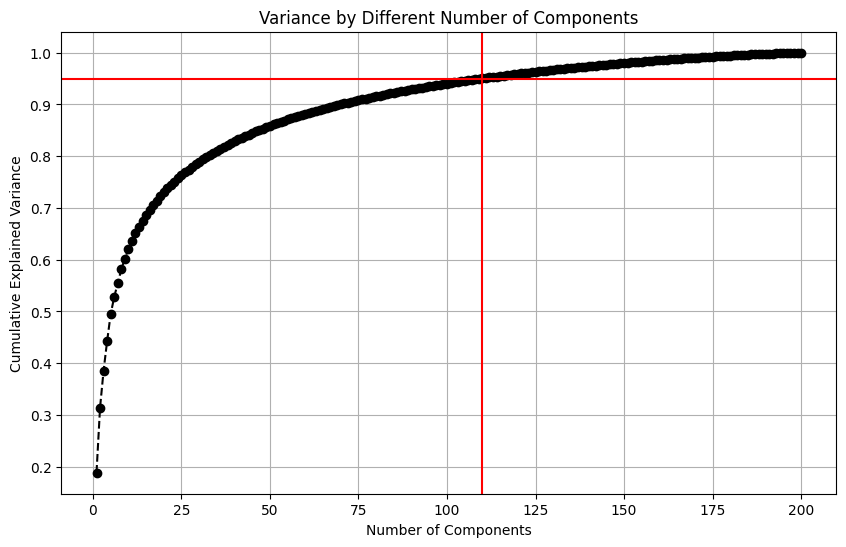

Number of components needed to retain 95% of the variance: 110


In [33]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--',color='black')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance by Different Number of Components')
plt.grid(True)
plt.axhline(y=0.95, color='red', linestyle='-')
plt.axvline(x=k, color='red', linestyle='-')
plt.show()

print("Number of components needed to retain 95% of the variance:", k)

accuracy of PCA and KPCA using my own functions vs sklearn

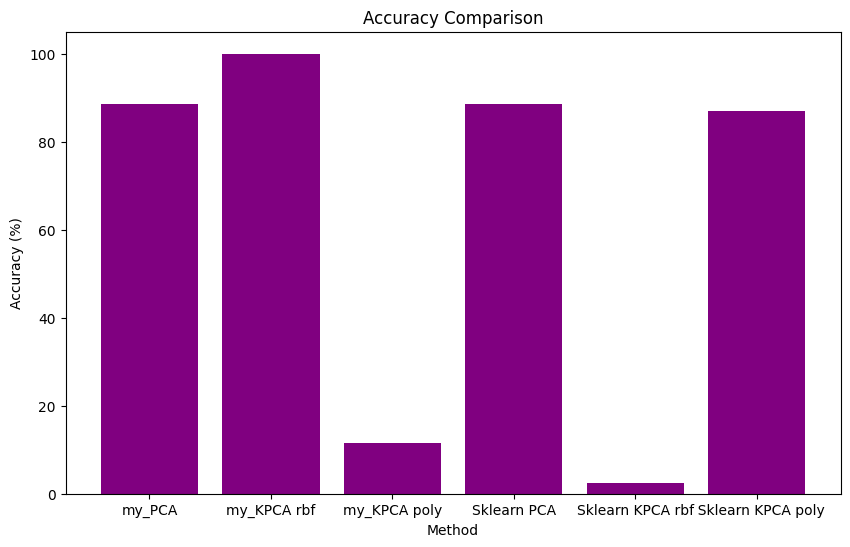

In [34]:
#accuracy bar plot
plt.figure(figsize=(10, 6))
plt.bar(['my_PCA', 'my_KPCA rbf', 'my_KPCA poly', 'Sklearn PCA','Sklearn KPCA rbf', '  Sklearn KPCA poly'], [accuracy*100, accuracy_rbf*100, accuracy_poly*100, sklearn_accuracy*100, sklearn_accuracy_rbf*100, sklearn_accuracy_poly*100],color='purple')
plt.xlabel('Method')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')
plt.show()

# Conclusion and Analysis

Principal Component Analysis (PCA) and Kernel Principal Component Analysis (KPCA) are both powerful tools in the realm of dimensionality reduction. PCA works amazing with linear data, whereas KPCA, with its kernel functions, can adeptly manage non-linear patterns. In this study, we utilized both custom-developed algorithms and the sklearn library to evaluate these techniques. Creating algorithms from scratch provides deep insights; however, it also introduces the complexities of extended development time and potential inaccuracies.


Alternatively, leveraging sklearn ensures a streamlined, optimized, and tested solution at the expense of potential adaptability for niche tasks. Using robust libraries like sklearn is often the more practical choice for efficiency and reliability in real-world applications.


# Extra 2 points:

a. compute the covariance matrix of the label attribute in the TrainData and print it.

In [35]:
label_covariance_matrix = np.cov(train_labels, rowvar=False)

label_covariance_matrix

print(label_covariance_matrix)

133.91959798994975
